In [1]:
import diamond
import pandas as pd
import numpy as np
import pickle
import os

from diamond.glms.logistic import LogisticRegression

In [2]:
import matplotlib.pyplot as plt
from plotnine import *
%matplotlib inline

/Users/tsweetser/.virtualenvs/stitch3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
priors_df = pd.DataFrame({'group': ['userId', 'movieId'],
                          'var1': ['intercept'] * 2,
                          'var2': [np.nan, np.nan],
                          'vcov': [0.9, 1.0]})

In [4]:
train_df = pd.read_csv('ml-20m/ratings.csv',
                       usecols=['userId', 'movieId', 'rating'])
train_df['liked'] = train_df['rating'] > 3.5

In [5]:
train_df.liked.mean()

0.49976392810434545

In [6]:
%%time
path = 'diamond.p'
if os.path.exists(path):
    with open(path, 'rb') as ff:
        m = pickle.load(ff)
else:
    m = LogisticRegression(train_df=train_df,
                           priors_df=priors_df)

    results = m.fit('liked ~ 1 + (1 | userId) + (1 | movieId)',
          tol=1e-5, max_its=200, verbose=True)
    with open('diamond.p', 'wb') as ff:
        pickle.dump(m, ff)

CPU times: user 606 ms, sys: 1.97 s, total: 2.58 s
Wall time: 2.93 s


How about just an $L_2$ regularized model?

In [7]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from scipy import sparse

Recycle design matrix from diamond. The only main effect is an intercept column, which we don't need.

In [8]:
X = sparse.hstack([x for d, x in m.grouping_designs.items() if d != 'main'])

In [9]:
%%time
m_sk = LogisticRegressionCV(fit_intercept=True, n_jobs=4)
y = train_df['liked'].astype(int).values
m_sk.fit(X, y)

CPU times: user 2min 43s, sys: 59 s, total: 3min 42s
Wall time: 24min 23s


In [10]:
m_sk.C_

array([ 0.00599484])

Now that we know our regularization, fit it once

In [11]:
%%time
m_sk = LogisticRegression(penalty='l2', C=m_sk.C_[0], fit_intercept=True)
m_sk.fit(X, y)

CPU times: user 53.2 s, sys: 6.7 s, total: 59.9 s
Wall time: 59.9 s


Compare predictions

In [12]:
%%time
pred_diamond = m.predict(train_df)

CPU times: user 42.7 s, sys: 15.2 s, total: 57.8 s
Wall time: 58.1 s


In [13]:
%%time
pred_skl = m_sk.predict_proba(X)[:, 1]

CPU times: user 2.88 s, sys: 384 ms, total: 3.26 s
Wall time: 3.26 s


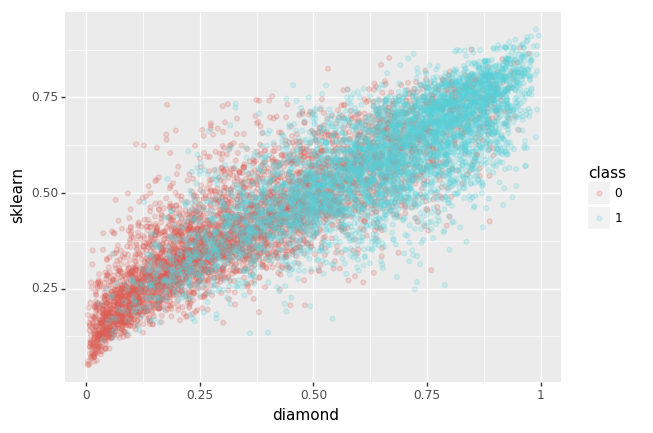

<ggplot: (-9223372036576869358)>

In [14]:
plot_idx = np.random.randint(0, len(pred_diamond), size=10000)
df_plot = pd.DataFrame({
    'diamond': pred_diamond[plot_idx],
    'sklearn': pred_skl[plot_idx],
    'class': y[plot_idx]
})
df_plot['class'] = df_plot['class'].astype(str)
(ggplot(df_plot, aes('diamond', 'sklearn', color='class')) +
        geom_point(alpha=0.2))